In [2]:
colab = False

try:
    import google.colab
    colab = True
except ImportError:
    colab = False

False


#START THE PROJECT






In [3]:
if(colab):
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/drive')
    %cd drive/MyDrive/PAIA/SkyDefender
    ! pip install -q kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
else:
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/alex/.kaggle’: File exists


#DOWNLOAD THE DATA

In [6]:
TRUE_CONDITIONS = ['y', 'yes']


# Download the dataset
delete_temp = input('\tYes(Y)/No(N): ')

if delete_temp.lower() in TRUE_CONDITIONS:
    ! mkdir ./download
    ! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset -p ./download
    # Unzip the dataset
    !mkdir -p ./data/raw
    !mkdir -p ./data/interim
    !unzip -j ./download/militaryaircraftdetectiondataset.zip "dataset/*" -d ./data/raw
    # Remove temporal files?
    !rm -rf ./download

100%|█████████████████████████████████████▉| 10.1G/10.1G [09:02<00:00, 23.0MB/s]
100%|██████████████████████████████████████| 10.1G/10.1G [09:02<00:00, 19.9MB/s]
Archive:  ./download/militaryaircraftdetectiondataset.zip
  inflating: ./data/raw/000106393cfe2343888c584e65fd2274.csv  
  inflating: ./data/raw/000106393cfe2343888c584e65fd2274.jpg  
  inflating: ./data/raw/00032844ab679240fc03ecd27d29a6aa.csv  
  inflating: ./data/raw/00032844ab679240fc03ecd27d29a6aa.jpg  
  inflating: ./data/raw/0003f56298fa8999168d7988a2e9549d.csv  
  inflating: ./data/raw/0003f56298fa8999168d7988a2e9549d.jpg  
  inflating: ./data/raw/000aa01b25574f28b654718db0700f72.csv  
  inflating: ./data/raw/000aa01b25574f28b654718db0700f72.jpg  
  inflating: ./data/raw/000e7662268a1071827c5a8663e773f9.csv  
  inflating: ./data/raw/000e7662268a1071827c5a8663e773f9.jpg  
  inflating: ./data/raw/000ec980b5b17156a55093b4bd6004ab.csv  
  inflating: ./data/raw/000ec980b5b17156a55093b4bd6004ab.jpg  
  inflating: ./data/raw/

In [8]:
!ls -l ./data/raw

total 8432216
-rw-rw-r-- 1 alex alex      111 may 12 09:02 000106393cfe2343888c584e65fd2274.csv
-rw-rw-r-- 1 alex alex   688121 may 12 09:02 000106393cfe2343888c584e65fd2274.jpg
-rw-rw-r-- 1 alex alex      110 may 12 09:02 00032844ab679240fc03ecd27d29a6aa.csv
-rw-rw-r-- 1 alex alex   247402 may 12 09:02 00032844ab679240fc03ecd27d29a6aa.jpg
-rw-rw-r-- 1 alex alex      181 may 12 09:02 0003f56298fa8999168d7988a2e9549d.csv
-rw-rw-r-- 1 alex alex  1918065 may 12 09:02 0003f56298fa8999168d7988a2e9549d.jpg
-rw-rw-r-- 1 alex alex      313 may 12 09:02 000aa01b25574f28b654718db0700f72.csv
-rw-rw-r-- 1 alex alex    58135 may 12 09:02 000aa01b25574f28b654718db0700f72.jpg
-rw-rw-r-- 1 alex alex      113 may 12 09:02 000e7662268a1071827c5a8663e773f9.csv
-rw-rw-r-- 1 alex alex   130881 may 12 09:02 000e7662268a1071827c5a8663e773f9.jpg
-rw-rw-r-- 1 alex alex      114 may 12 09:02 000ec980b5b17156a55093b4bd6004ab.csv
-rw-rw-r-- 1 alex alex    57205 may 12 09:02 000ec980b5b17156a55093b4bd6004ab.jpg
-r

#USING THE DATA

##UNDERSTANDING THE DATASET

In [11]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [12]:
csv_path = "./data/raw/"
df = pd.concat([pd.read_csv(csv_path + f, delimiter=',') for f in os.listdir(csv_path) if f.endswith('.csv')], ignore_index=True)

In [13]:
df.to_csv('./data/interim/merged_info.csv', index=False)

In [14]:
if df.isnull().values.any():
    print("There are null values in DF")
else:
    print("No null values in DF.")

No null values in DF.


In [15]:
df.head()

filename  width  height class  xmin  ymin  xmax   
0  c63ae96d05c500d4ab9806f3ae58e122   2048    1365   F16   193   372   826  \
1  c63ae96d05c500d4ab9806f3ae58e122   2048    1365   F35  1085   420  1771   
2  d09666116b6026142d28eba8e82accc6   1200     800   V22   510   563   759   
3  43139586ca5df4d371243edff3ccc042   1800    1200   F35   477   263   577   
4  43139586ca5df4d371243edff3ccc042   1800    1200   F15  1349   959  1475   

   ymax  
0   984  
1   984  
2   644  
3   295  
4   993

<Axes: ylabel='count'>

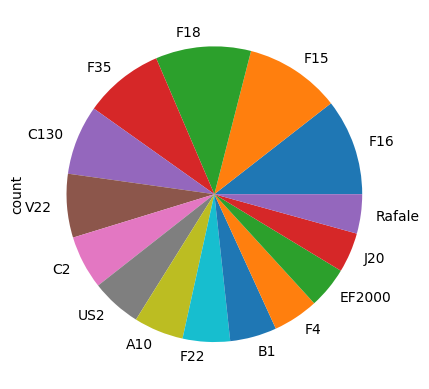

In [16]:
df["class"].value_counts().head(15).plot(kind="pie") #See where can we reduce a bit our dataset

Reduced from 17968 rows to 3162 rows


<Axes: ylabel='count'>

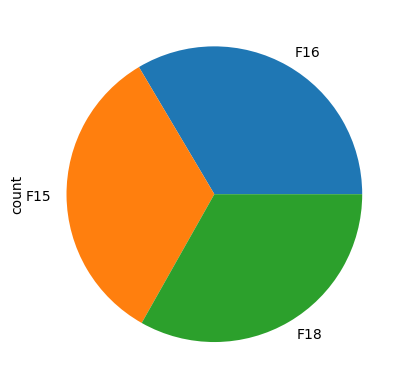

In [18]:
target = ["F16", "F15", "F18"] #Classes we want to keep

df_reduced = df.loc[df["class"].isin(target)].copy(deep=True)

print(f"Reduced from {len(df.index)} rows to {len(df_reduced.index)} rows")
df_reduced["class"].value_counts().plot(kind="pie")

In [19]:
# Image location
images_dir = './data/raw/'

df_clean = df_reduced.copy(deep = True)

# Add the filepath to the image into the dataframe
df_clean['filepath'] = images_dir + df['filename'] + '.jpg'
df_clean.head()

filename  width  height class  xmin  ymin  xmax   
0   c63ae96d05c500d4ab9806f3ae58e122   2048    1365   F16   193   372   826  \
4   43139586ca5df4d371243edff3ccc042   1800    1200   F15  1349   959  1475   
9   5f57bc06c34226b3f371ba5bab097b1c   1800    1200   F18   138   195   193   
10  5f57bc06c34226b3f371ba5bab097b1c   1800    1200   F18  1257   382  1342   
33  bc02bc3564f44267ef9ff6baa4dfbede   1800    1200   F15    87   179   727   

    ymax                                         filepath  
0    984  ./data/raw/c63ae96d05c500d4ab9806f3ae58e122.jpg  
4    993  ./data/raw/43139586ca5df4d371243edff3ccc042.jpg  
9    217  ./data/raw/5f57bc06c34226b3f371ba5bab097b1c.jpg  
10   418  ./data/raw/5f57bc06c34226b3f371ba5bab097b1c.jpg  
33   583  ./data/raw/bc02bc3564f44267ef9ff6baa4dfbede.jpg

In [20]:
df_img = df_clean.copy(deep = True)
height = 256
width = 256
# Iteración sobre el dataframe
for index, row in df_clean.iterrows():
    # Leer la ruta de la imagen del dataframe
    filepath = row['filepath']
    
    # Cargar la imagen utilizando TensorFlow
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(height, width))  # Ajusta height y width a tus dimensiones deseadas
    
    # Convertir la imagen a un arreglo numpy
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Normalizar los valores de píxel a un rango entre 0 y 1
    img_array /= 255.0
    
    # Calcular las coordenadas normalizadas
    x_min = row['xmin'] / width
    y_min = row['ymin'] / height
    x_max = row['xmax'] / width
    y_max = row['ymax'] / height
    
    # Obtener la etiqueta de clase
    label = row['class']
    
    # Guardar las coordenadas normalizadas y la etiqueta en el dataframe
    df_img.at[index, 'x_min_norm'] = x_min
    df_img.at[index, 'y_min_norm'] = y_min
    df_img.at[index, 'x_max_norm'] = x_max
    df_img.at[index, 'y_max_norm'] = y_max
    df_img.at[index, 'label'] = label

In [21]:
image = keras.utils.load_img("./data/raw/627336ac6a53a9e90a71ccd9f95294c1.jpg")

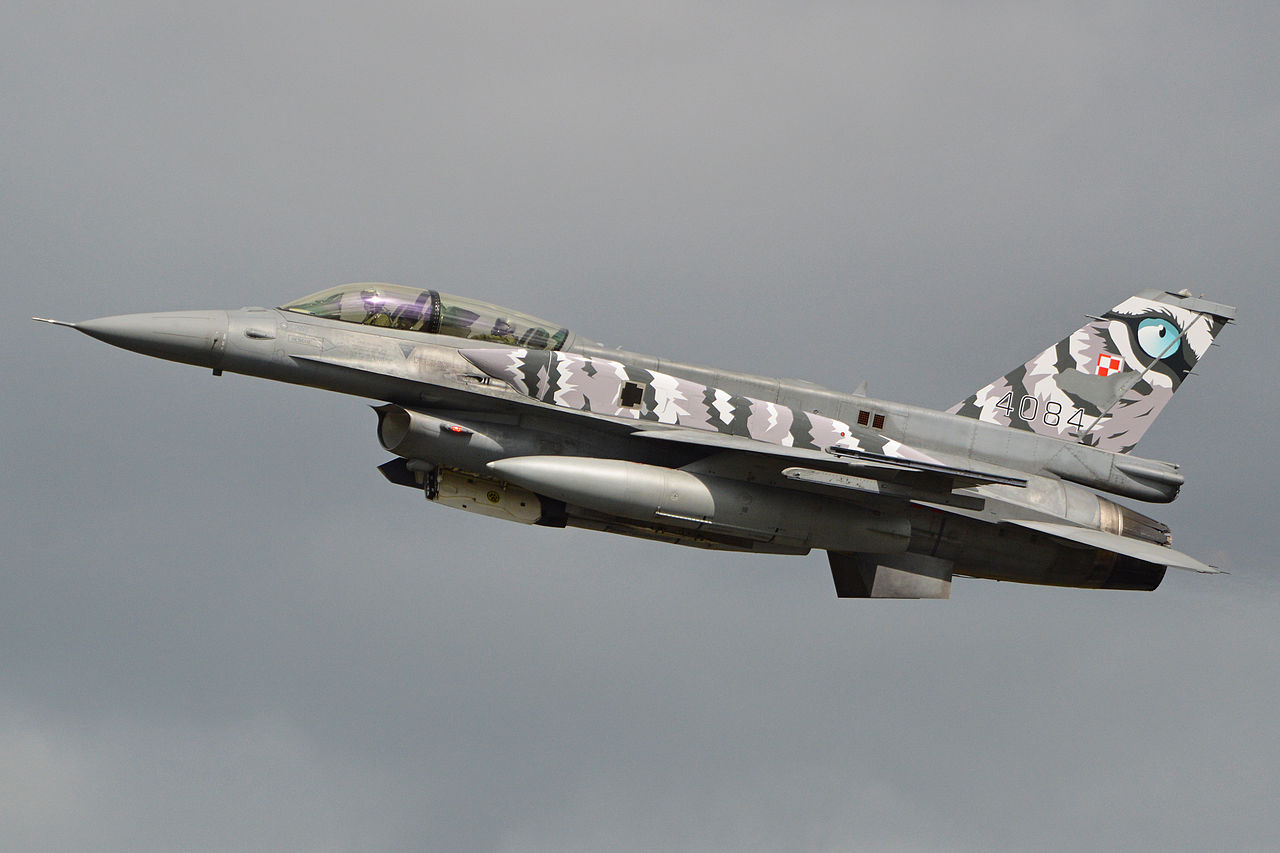

In [22]:
image

##TRAIN/TEST SEPARATION

In [ ]:
#Create Train and Test sets
train_dfs = []
test_dfs = []

grouped = df_clean.groupby('class') 

for category, group_df in grouped:
    # Divide the sets
    train_df, test_df = train_test_split(group_df, test_size=0.2, random_state=42) #For each group, we set an 80% train 20%test
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [ ]:
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

In [ ]:
print(test_df.head())
print("------------------------")
print("Total: " + str(len(test_df)))

In [ ]:
print(train_df.head())
print("------------------------")
print("Total: "+ str(len(train_df)))